In [19]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple
from torch import Tensor

In [20]:
from IPython.display import clear_output
from random import sample

In [21]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


with open('/content/drive/MyDrive/data/lyrics.json', 'r') as file:
    text = json.load(file)


def split_song(lyrics):
    verses = []
    chorus = []
    is_chorus = False

    for line in lyrics:
        line = line.strip()
        if line.startswith("[Куплет") or line.startswith("[Verse"):
            is_chorus = False
        elif line.startswith("[Припев") or line.startswith("[Chorus"):
            is_chorus = True
        elif is_chorus:
            chorus.append(line)
        else:
            verses.append(line)

    return verses, chorus


text = ''.join(text)
lines = text.split("\n")


lines = [line for line in lines if line.strip()]


tokens = set(" ".join(lines))
tokens = sorted(tokens)


token_to_id = {symbol: index for index, symbol in enumerate(tokens, start=1)}
token_to_id['<PAD>'] = 0
n_tokens = len(token_to_id)


class SymbolDataset(Dataset):
    def __init__(self, data, token_to_ids, batch_size=16):
        self.data = data
        self.token_to_ids = token_to_ids
        self.batch_size = batch_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        symbols = [self.token_to_ids[symbol] for symbol in self.data[index]]
        return symbols


def collation(batch):
    max_len = max(len(symbols) for symbols in batch)
    batch_tensor = torch.zeros(len(batch), max_len, dtype=torch.long)

    for i, symbols in enumerate(batch):
        batch_tensor[i, :len(symbols)] = torch.tensor(symbols)

    return batch_tensor


train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)


train_dataset = SymbolDataset(train_lines, token_to_id)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collation)

test_dataset = SymbolDataset(test_lines, token_to_id)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collation)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collation, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collation, pin_memory=True)


In [22]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        super().__init__()

        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.lr = nn.Linear(hid_size, n_tokens)



    def __call__(self, input_ix):
        emb = self.emb(input_ix)
        out, (h, c) = self.rnn(emb)
        out = self.lr(out)
        return out

In [23]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        super().__init__()
        stride = 1
        kernel_size = 5
        num_leading_zeros = (kernel_size - 1) * stride
        self.embedding = nn.Embedding(n_tokens, emb_size, padding_idx=token_to_id[PAD])
        self.padding = nn.ZeroPad2d((num_leading_zeros, 0, 0, 0))
        self.conv = nn.Conv1d(emb_size, hid_size, kernel_size=kernel_size, stride=stride)
        self.lr = nn.Linear(hid_size, n_tokens)


    def __call__(self, input_ix):
        emb = self.embedding(input_ix)
        emb = emb.permute(0, 2, 1)
        padded = self.padding(emb)
        conved = self.conv(padded)
        relu = F.relu(conved)
        relu = relu.permute(0, 2, 1)
        out = self.lr(relu)
        return out

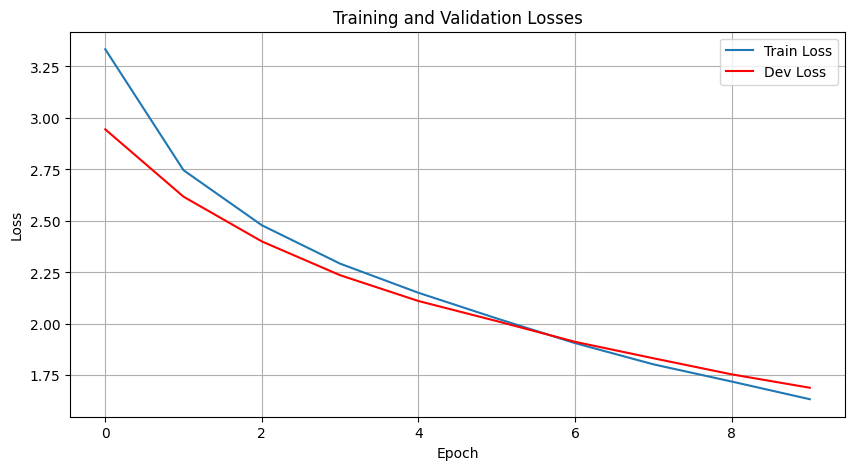

In [24]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, targets = batch[:, :-1].to(device), batch[:, 1:].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, n_tokens)
        loss = criterion(outputs, targets.flatten())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch[:, :-1].to(device), batch[:, 1:].to(device)
            outputs = model(inputs)
            outputs = outputs.view(-1, n_tokens)
            loss = criterion(outputs, targets.flatten())
            total_loss += loss.item()

    return total_loss / len(data_loader)

def plot_losses(train_losses, dev_losses=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    if dev_losses:
        plt.plot(dev_losses, label='Dev Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


PAD = "<PAD>"


model = FixedWindowLanguageModel().to(device)
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id[PAD])

train_losses = []
dev_losses = []
for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    dev_loss = evaluate(model, test_loader, criterion, device)
    dev_losses.append(dev_loss)

    clear_output(True)
    plot_losses(train_losses, dev_losses)


model_rnn = RNNLanguageModel().to(device)
optimizer = Adam(model_rnn.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id[PAD])

train_losses_rnn = []
dev_losses_rnn = []
for epoch in range(10):
    train_loss = train_epoch(model_rnn, train_loader, optimizer, criterion, device)
    train_losses_rnn.append(train_loss)

    dev_loss = evaluate(model_rnn, test_loader, criterion, device)
    dev_losses_rnn.append(dev_loss)

    clear_output(True)
    plot_losses(train_losses_rnn, dev_losses_rnn)


In [25]:
from typing import List, Dict

id_to_token: Dict[int, str] = {i: symbol for symbol, i in token_to_id.items()}

In [26]:
EOS = "\n"
if EOS not in token_to_id:
    token_to_id[EOS] = len(token_to_id)

In [27]:
def generate_text(model, prompt, max_len=512, temperature=0):
    device = next(model.parameters()).device
    token_ids = [token_to_id[symbol] for symbol in prompt]
    input_tensor = torch.tensor(token_ids, dtype=torch.long, device=device).unsqueeze(0)
    generated_text = prompt

    model.eval()
    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor)
            output = output[:, -1, :]

            if temperature == 0:
                _, ind = torch.max(output, dim=1)
            else:
                probs = F.softmax(output / temperature, dim=1)
                ind = torch.multinomial(probs.squeeze(), 1)

            token = ind.item()
            generated_text += id_to_token[token]
            if token == token_to_id[EOS] or len(generated_text) >= max_len:
                break

            input_tensor = torch.cat([input_tensor, ind.unsqueeze(0)], dim=1)

    return generated_text

# Генерация текста для модели FixedWindowLanguageModel
text_fixed_window = generate_text(model, "люблю ", temperature=0.2)
print('Генерация текста для модели FixedWindowLanguageModel')
print(text_fixed_window)

# Генерация текста для модели RNNLanguageModel
text_rnn = generate_text(model_rnn, "Подарок ", temperature=0.2)
print('\nГенерация текста для модели RNNLanguageModel')
print(text_rnn)


Генерация текста для модели FixedWindowLanguageModel
люблю тебя в половать сто снова мыли когда в отрусто снова сто тебя в полова все мона, не сто тебя любил тебя в польно не не польне не припля всё тебя в половать меня в это тебя в номой дольно не посет потолько в мороче в ну меня в домой польно в это тебя в страза твои головать так снова в знесь в домоны, день в номой состаль тебя в полова мы не не не в номой на всё как в не не поснова не не всё тебя в польно не не не не не польная не не все меня в долоче в номо не не ты провить сти долоче в стот себя в пол

Генерация текста для модели RNNLanguageModel
Подарок тебя в последний раз мои друзья, как мы не винают в постель в последний в кого ты все домо в последний спаси меня в мои голова в кого в последний раз?, пока я спить, не помно в последная покомо с тобой ды сторай, как по просто с тобой делова по просто с тобой ды так просто тебя по проводала в моей всё запишь и стирай, цикли мои глаза в последний последний спаси меня в кого тебя